# Fannie Mae

## Import Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill
import random

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from xgboost import XGBRegressor

from patsy import dmatrices, dmatrix, build_design_matrices

from xgboost.sklearn import XGBClassifier
import xgboost as xgb

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load the Data 

In [3]:
col_classes = {"LOAN_IDENTIFIER": np.character, 
               "CHANNEL": 'category', 
               "SELLER_NAME": np.character, 
               "ORIGINAL_INTEREST_RATE": np.float32, 
               "ORIGINAL_UPB": np.float64,
               "ORIGINAL_LOAN_TERM": "Int16", 
               "ORIGINATION_DATE": np.character,
               "FIRST_PAYMENT_DATE": np.character, 
               "ORIGINAL_LTV": np.float32, 
               "ORIGINAL_COMBINED_LTV": np.float32, 
               "NUMBER_OF_BORROWERS": 'category', 
               "DTI": np.float32, 
               "BORROWER_CREDIT_SCORE_AT_ORIGINATION": "UInt16", 
               "COBORROWER_CREDIT_SCORE_AT_ORIGINATION": 'UInt16', 
               "FIRST_TIME_HOME_BUYER_INDICATOR": 'category', 
               "LOAN_PURPOSE": 'category', 
               "PROPERTY_TYPE": 'category',
               "NUMBER_OF_UNITS": "UInt16", 
               "OCCUPANCY_STATUS": 'category', 
               "PROPERTY_STATE": 'category', 
               "MSA": 'category', 
               "ZIP_CODE_SHORT": 'category', 
               "MORTGAGE_INSURANCE_PERCENTAGE": np.float32, 
               "AMORTIZATION_TYPE": np.character,
               "MORTGAGE_INSURANCE_TYPE": 'category', 
               "RELOCATION_MORTGAGE_INDICATOR": 'category',
               "CREDIT_SCORE_MIN": "UInt16",
               "ORIGINAL_VALUE": float,
               "ZERO_BALANCE_CODE": 'category',
               "LOAN_AGE": "Int16",
               "NET_LOSS": float,
               "NET_SEVERITY": float,
               "LAST_STAT": 'category',
               "LOAN_MODIFICATION_COSTS": float,
               "TOTAL_LOSSES": float,
               "MSA_NAME": 'category',
               "CENSUS_2010_POP": float}

date_columns = ["ORIGINATION_DATE",
                "FIRST_PAYMENT_DATE"]

In [4]:
%%time

full_data_set = False

FILES_LOCATION = '../Shared Data (Read Only)/Fannie Mae Data/'

if not full_data_set:
    df_train = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTrain.csv",
                           index_col="LOAN_IDENTIFIER",
                           dtype=col_classes,
                           parse_dates=date_columns,
                           sep='|')
    df_test = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

if full_data_set:
    # This p is the proportion of the training data you load.
    # You can set it anywhere from 0 to 1.
    p = 1
    random.seed(201)
    df_train = pd.read_csv(FILES_LOCATION + "FannieMaeTrain.csv",
                           index_col="LOAN_IDENTIFIER",
                           dtype=col_classes,
                           parse_dates=date_columns,
                           sep='|',
                           skiprows=lambda i: i>0 and random.random() > p)
    df_test = pd.read_csv(FILES_LOCATION + "FannieMaeTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

CPU times: user 6.18 s, sys: 296 ms, total: 6.48 s
Wall time: 6.6 s


In [5]:
df_train.shape

(493073, 36)

In [6]:
df_test.shape

(493073, 36)

## Summarize the Data

In [7]:
if 'ZERO_BALANCE_CODE' in df_train:
    df_train.drop(['ZERO_BALANCE_CODE', 'LOAN_AGE', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS', 'TOTAL_LOSSES'],
                  axis=1,
                  inplace=True)
if 'ZERO_BALANCE_CODE' in df_test:
    df_test.drop(['ZERO_BALANCE_CODE', 'LOAN_AGE', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS', 'TOTAL_LOSSES'],
                  axis=1,
                  inplace=True)

In [8]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all', datetime_is_numeric=True).transpose()], axis=1).fillna(""))

In [9]:
summarize_dataframe(df_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,category,0,3,493073.0,3,R,257680,,,,,,,
SELLER_NAME,object,0,143,493073.0,143,Other,180983,,,,,,,
ORIGINAL_INTEREST_RATE,float32,1,1960,493072.0,,,,4.917918,1.75,3.875,4.75,5.875,12.125,1.381413
ORIGINAL_UPB,float64,0,831,493073.0,,,,205186.96623,6000.0,116000.0,179000.0,269000.0,1269000.0,118997.809289
ORIGINAL_LOAN_TERM,Int16,0,204,493073.0,,,,310.4345,60.0,240.0,360.0,360.0,360.0,80.317014
ORIGINATION_DATE,datetime64[ns],0,267,493073.0,,,,2010-09-17 11:51:27.021191680,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,493073.0,,,,2010-11-17 13:53:54.489822208,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float32,0,96,493073.0,,,,70.482384,2.0,60.0,75.0,80.0,97.0,17.552217
ORIGINAL_COMBINED_LTV,float32,0,124,493073.0,,,,71.231705,2.0,61.0,75.0,80.0,158.0,17.620892
NUMBER_OF_BORROWERS,category,109,7,492964.0,7,2,273507,,,,,,,


In [10]:
summarize_dataframe(df_test)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,category,0,3,493073.0,3,R,257609,,,,,,,
SELLER_NAME,object,0,144,493073.0,144,Other,181007,,,,,,,
ORIGINAL_INTEREST_RATE,float32,0,1994,493073.0,,,,4.917481,1.75,3.875,4.75,5.875,11.625,1.384845
ORIGINAL_UPB,float64,0,844,493073.0,,,,205485.463613,8000.0,116000.0,179000.0,270000.0,1473000.0,119123.262314
ORIGINAL_LOAN_TERM,Int16,0,201,493073.0,,,,310.492996,60.0,240.0,360.0,360.0,360.0,80.312096
ORIGINATION_DATE,datetime64[ns],0,267,493073.0,,,,2010-09-17 05:33:07.161333248,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,493073.0,,,,2010-11-17 07:39:02.274673408,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float32,0,97,493073.0,,,,70.454559,1.0,60.0,75.0,80.0,97.0,17.539341
ORIGINAL_COMBINED_LTV,float32,0,127,493073.0,,,,71.187462,1.0,61.0,75.0,80.0,157.0,17.601181
NUMBER_OF_BORROWERS,category,101,9,492972.0,9,2,273611,,,,,,,


## Engineer Row Based Features

In [11]:
df_train['ORIGINATION_DATE'] = pd.to_datetime(df_train['ORIGINATION_DATE'], format='%Y-%m-%d')

df_test['ORIGINATION_DATE'] = pd.to_datetime(df_test['ORIGINATION_DATE'], format='%Y-%m-%d')

In [12]:
df_train['YEAR'] = df_train['ORIGINATION_DATE'].dt.year
df_test['YEAR'] = df_test['ORIGINATION_DATE'].dt.year

In [13]:
#Create range to single out recession years
date1 = "2005/07/01"
date2 = "2008/02/01"

newdate1 = pd.to_datetime(date1, format='%Y/%m/%d')
newdate2 = pd.to_datetime(date2, format='%Y/%m/%d')

In [14]:
#BadYears variable to train tree on recession years
df_train['BadYears'] = df_train['ORIGINATION_DATE'].apply(lambda x: True if (x>newdate1 and x<newdate2) else False)
df_test['BadYears'] = df_test['ORIGINATION_DATE'].apply(lambda x: True if (x>newdate1 and x<newdate2) else False)

In [15]:
#BadState variable to train trees on states that saw a high net loss during the recession
df_train['BadState'] = df_train['PROPERTY_STATE'].apply(lambda x: True if (x=='NV' or x=='FL' or x=='AZ' or x=='CA' or x=='MI') else False)
df_test['BadState'] = df_test['PROPERTY_STATE'].apply(lambda x: True if (x=='NV' or x=='FL' or x=='AZ' or x=='CA' or x=='MI') else False)

## Split Into Training and Validation

In [16]:
df_smaller_train, df_validation = train_test_split(df_train, test_size = 0.25, random_state = 201)

In [17]:
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

## Impute Missing Values

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom defined imputer for categorical data. This allows you to specify an 
    other class where any category that doesn't meet the requirements necessary to
    be in 
    """
    
    def __init__(self, other_threshold=0, 
                 other_label="OTHER",
                 missing_first=True,
                 missing_values=np.nan, 
                 strategy='constant', 
                 fill_value="MISSING", 
                 verbose=0, 
                 copy=True, 
                 add_indicator=False):
        self.add_indicator = add_indicator
        self.copy=copy
        self.verbose=verbose
        self.fill_value=fill_value
        self.missing_first=missing_first
        self.missing_values=missing_values
        self.other_label=other_label
        self.other_threshold=other_threshold
        self.strategy=strategy
        if hasattr(missing_values, "__iter__"):
            self.missing_values = missing_values
        else:
            self.missing_values = [missing_values]
        self._imputer = SimpleImputer(missing_values=missing_values, strategy=strategy, fill_value=fill_value, verbose=verbose, copy=copy, add_indicator=False)
        self._column_categories = {}

        
    def fit(self, X, y=None):
        if type(self.other_threshold) == int or type(self.other_threshold) == float:
            other_threshold = [self.other_threshold]*len(X.columns)
        elif len(self.other_threshold) == len(X.columns):
            other_threshold = self.other_threshold
        else:
            raise TypeError("other_threshold must be either a single number or a list of numbers equal to the number of columns.")

        i = 0
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        column_categories = {}
        for column in X.columns:
            if other_threshold[i] < 1:
                other_threshold[i] = other_threshold[i]*X[column].shape[0]
            
            value_counts = X[column].value_counts()
            categories = [category for category in value_counts.index if value_counts.loc[category] >= other_threshold[i]]
            if value_counts.iloc[-1] >= other_threshold[i]:
                categories[-1] = self.other_label
            else:
                categories.append(self.other_label)
            
            self._column_categories[column] = categories
            i = i + 1
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        for column in X.columns:
            X.loc[~X[column].isin(self._column_categories[column]) & ~X[column].isin(self.missing_values), column] = self.other_label
        return pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)[:].astype(str)

In [19]:
list(df_smaller_train.columns)

['CHANNEL',
 'SELLER_NAME',
 'ORIGINAL_INTEREST_RATE',
 'ORIGINAL_UPB',
 'ORIGINAL_LOAN_TERM',
 'ORIGINATION_DATE',
 'FIRST_PAYMENT_DATE',
 'ORIGINAL_LTV',
 'ORIGINAL_COMBINED_LTV',
 'NUMBER_OF_BORROWERS',
 'DTI',
 'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
 'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
 'FIRST_TIME_HOME_BUYER_INDICATOR',
 'LOAN_PURPOSE',
 'PROPERTY_TYPE',
 'NUMBER_OF_UNITS',
 'OCCUPANCY_STATUS',
 'PROPERTY_STATE',
 'MSA',
 'ZIP_CODE_SHORT',
 'MORTGAGE_INSURANCE_PERCENTAGE',
 'AMORTIZATION_TYPE',
 'MORTGAGE_INSURANCE_TYPE',
 'RELOCATION_MORTGAGE_INDICATOR',
 'CREDIT_SCORE_MIN',
 'ORIGINAL_VALUE',
 'NET_LOSS',
 'MSA_NAME',
 'CENSUS_2010_POP',
 'YEAR',
 'BadYears',
 'BadState']

In [20]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
#include missing imputer for first time homebuyer, mortgage insurance type, and bad years/bad state
imputer_missing = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')
categorical_imputer = CategoricalImputer(other_threshold=.01)

In [21]:
continuous_mean = ['ORIGINAL_INTEREST_RATE',
                   'ORIGINAL_UPB',
                   'ORIGINAL_LOAN_TERM',
                   'ORIGINAL_LTV',
                   'ORIGINAL_COMBINED_LTV',
                   'ORIGINAL_VALUE',
                   'YEAR']

continuous_zero = ['MORTGAGE_INSURANCE_PERCENTAGE', 
                   'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
                   'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
                   'CREDIT_SCORE_MIN',
                   'DTI']

continuous_variables = continuous_mean + continuous_zero

categorical_missing = ['FIRST_TIME_HOME_BUYER_INDICATOR',
                       'MORTGAGE_INSURANCE_TYPE','BadYears','BadState']

categorical_variables = ['CHANNEL',
                         'SELLER_NAME',
                         'NUMBER_OF_BORROWERS',
                         'LOAN_PURPOSE',
                         'PROPERTY_TYPE',
                         'NUMBER_OF_UNITS',
                         'OCCUPANCY_STATUS',
                         'PROPERTY_STATE',
                         'ZIP_CODE_SHORT',
                         'AMORTIZATION_TYPE',
                         'RELOCATION_MORTGAGE_INDICATOR',
                         'MSA',
                         'MSA_NAME',
                         'CENSUS_2010_POP']

In [22]:
imputer_mean.fit(df_smaller_train[continuous_mean])
df_smaller_train[continuous_mean] = imputer_mean.transform(df_smaller_train[continuous_mean])
df_validation[continuous_mean] = imputer_mean.transform(df_validation[continuous_mean])

In [23]:
imputer_zero.fit(df_smaller_train[continuous_zero])
df_smaller_train[continuous_zero] = imputer_zero.transform(df_smaller_train[continuous_zero])
df_validation[continuous_zero] = imputer_zero.transform(df_validation[continuous_zero])

In [24]:
categorical_imputer.fit(df_smaller_train[categorical_variables])
df_smaller_train[categorical_variables] = categorical_imputer.transform(df_smaller_train[categorical_variables])
df_validation[categorical_variables] = categorical_imputer.transform(df_validation[categorical_variables])

In [25]:
imputer_missing.fit(df_smaller_train[categorical_missing])
df_smaller_train[categorical_missing] = imputer_missing.transform(df_smaller_train[categorical_missing])
df_validation[categorical_missing] = imputer_missing.transform(df_validation[categorical_missing])

In [26]:
summarize_dataframe(df_smaller_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,object,0,3,369804.0,3,R,193339,,,,,,,
SELLER_NAME,object,0,13,369804.0,13,Other,135691,,,,,,,
ORIGINAL_INTEREST_RATE,float64,0,1719,369804.0,,,,4.918824,1.75,3.875,4.75,5.875,12.125,1.381747
ORIGINAL_UPB,float64,0,820,369804.0,,,,204962.236752,6000.0,116000.0,178000.0,268000.0,1269000.0,118829.227289
ORIGINAL_LOAN_TERM,float64,0,196,369804.0,,,,310.443689,60.0,240.0,360.0,360.0,360.0,80.318952
ORIGINATION_DATE,datetime64[ns],0,267,369804.0,,,,2010-09-16 12:00:17.990070784,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,369804.0,,,,2010-11-16 14:03:52.001817088,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float64,0,96,369804.0,,,,70.468143,2.0,60.0,75.0,80.0,97.0,17.56641
ORIGINAL_COMBINED_LTV,float64,0,121,369804.0,,,,71.212096,2.0,61.0,75.0,80.0,149.0,17.625818
NUMBER_OF_BORROWERS,object,0,3,369804.0,3,2,205267,,,,,,,


## Set Up the Evaluation Metric

In [27]:
average_loss = df_train['NET_LOSS'].mean()

In [28]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    RMSE = mean_squared_error(y_true, y_pred)**(1/2)
    naive_RMSE = mean_squared_error(y_true, [average_loss]*len(y_true))**(1/2)
    acc_df = pd.DataFrame(data = {"RMSE": [RMSE],
                                  "Naive - RMSE": [naive_RMSE - RMSE]})
    display(acc_df.style.hide_index())

## Feature Engineering for Tree Based Models

In [29]:
continuous_features_trees = ['ORIGINAL_LTV', 'DTI', 'CREDIT_SCORE_MIN','ORIGINAL_INTEREST_RATE','ORIGINAL_UPB','COBORROWER_CREDIT_SCORE_AT_ORIGINATION','BORROWER_CREDIT_SCORE_AT_ORIGINATION']
cat_ordinal_features_trees = ['PROPERTY_STATE','OCCUPANCY_STATUS','LOAN_PURPOSE','MORTGAGE_INSURANCE_TYPE','NUMBER_OF_BORROWERS','MSA','CHANNEL']
cat_dummy_features_trees = ['FIRST_TIME_HOME_BUYER_INDICATOR']

In [30]:
X_tree_train = df_smaller_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train = df_smaller_train['NET_LOSS']

In [31]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees)  +"+BadYears:MSA" + "+BadState:YEAR" + "+FIRST_TIME_HOME_BUYER_INDICATOR:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE"

In [32]:
formula_tree

'0 + FIRST_TIME_HOME_BUYER_INDICATOR+BadYears:MSA+BadState:YEAR+FIRST_TIME_HOME_BUYER_INDICATOR:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE'

In [33]:
X_tree_train_patsy = dmatrix(formula_tree, df_smaller_train, return_type="dataframe")

In [34]:
X_tree_train_patsy

,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[Y],FIRST_TIME_HOME_BUYER_INDICATOR[missing],MSA[T.12060],MSA[T.14460],MSA[T.16980],MSA[T.19100],MSA[T.19740],MSA[T.19820],MSA[T.26420],MSA[T.31080],MSA[T.31100],MSA[T.33100],MSA[T.33460],MSA[T.35620],MSA[T.37980],MSA[T.38060],MSA[T.38900],MSA[T.40140],MSA[T.40900],MSA[T.41180],MSA[T.41740],MSA[T.41860],MSA[T.42660],MSA[T.47900],MSA[T.OTHER],BadYears[T.True]:MSA[0],BadYears[T.True]:MSA[12060],BadYears[T.True]:MSA[14460],BadYears[T.True]:MSA[16980],BadYears[T.True]:MSA[19100],BadYears[T.True]:MSA[19740],BadYears[T.True]:MSA[19820],BadYears[T.True]:MSA[26420],BadYears[T.True]:MSA[31080],BadYears[T.True]:MSA[31100],BadYears[T.True]:MSA[33100],BadYears[T.True]:MSA[33460],BadYears[T.True]:MSA[35620],BadYears[T.True]:MSA[37980],BadYears[T.True]:MSA[38060],BadYears[T.True]:MSA[38900],BadYears[T.True]:MSA[40140],BadYears[T.True]:MSA[40900],BadYears[T.True]:MSA[41180],BadYears[T.True]:MSA[41740],BadYears[T.True]:MSA[41860],BadYears[T.True]:MSA[42660],BadYears[T.True]:MSA[47900],BadYears[T.True]:MSA[OTHER],BadState[False]:YEAR,BadState[True]:YEAR,FIRST_TIME_HOME_BUYER_INDICATOR[N]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,FIRST_TIME_HOME_BUYER_INDICATOR[Y]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,FIRST_TIME_HOME_BUYER_INDICATOR[missing]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
366756076746,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001.0,0.0,4458.750,0.0,0.0
922055643120,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,0.0,4181.750,0.0,0.0
567167163612,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3357.500,0.0,0.0
537298100693,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2007.0,0.0,4425.000,0.0,0.0
414054555648,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001.0,0.0,4940.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833696160226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,0.0,3602.625,0.0,0.0
943668997502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016.0,0.0,1903.000,0.0,0.0
128751700926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,0.0,3815.625,0.0,0.0


In [35]:
X_tree_train = pd.concat([X_tree_train, X_tree_train_patsy], axis=1)

In [36]:
X_tree_train

,ORIGINAL_LTV,DTI,CREDIT_SCORE_MIN,ORIGINAL_INTEREST_RATE,ORIGINAL_UPB,COBORROWER_CREDIT_SCORE_AT_ORIGINATION,BORROWER_CREDIT_SCORE_AT_ORIGINATION,PROPERTY_STATE,OCCUPANCY_STATUS,LOAN_PURPOSE,MORTGAGE_INSURANCE_TYPE,NUMBER_OF_BORROWERS,MSA,CHANNEL,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[Y],FIRST_TIME_HOME_BUYER_INDICATOR[missing],MSA[T.12060],MSA[T.14460],MSA[T.16980],MSA[T.19100],MSA[T.19740],MSA[T.19820],MSA[T.26420],MSA[T.31080],MSA[T.31100],MSA[T.33100],MSA[T.33460],MSA[T.35620],MSA[T.37980],MSA[T.38060],MSA[T.38900],MSA[T.40140],MSA[T.40900],MSA[T.41180],MSA[T.41740],MSA[T.41860],MSA[T.42660],MSA[T.47900],MSA[T.OTHER],BadYears[T.True]:MSA[0],BadYears[T.True]:MSA[12060],BadYears[T.True]:MSA[14460],BadYears[T.True]:MSA[16980],BadYears[T.True]:MSA[19100],BadYears[T.True]:MSA[19740],BadYears[T.True]:MSA[19820],BadYears[T.True]:MSA[26420],BadYears[T.True]:MSA[31080],BadYears[T.True]:MSA[31100],BadYears[T.True]:MSA[33100],BadYears[T.True]:MSA[33460],BadYears[T.True]:MSA[35620],BadYears[T.True]:MSA[37980],BadYears[T.True]:MSA[38060],BadYears[T.True]:MSA[38900],BadYears[T.True]:MSA[40140],BadYears[T.True]:MSA[40900],BadYears[T.True]:MSA[41180],BadYears[T.True]:MSA[41740],BadYears[T.True]:MSA[41860],BadYears[T.True]:MSA[42660],BadYears[T.True]:MSA[47900],BadYears[T.True]:MSA[OTHER],BadState[False]:YEAR,BadState[True]:YEAR,FIRST_TIME_HOME_BUYER_INDICATOR[N]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,FIRST_TIME_HOME_BUYER_INDICATOR[Y]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,FIRST_TIME_HOME_BUYER_INDICATOR[missing]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
366756076746,55.0,61.0,615.0,7.250,30000.0,698.0,615.0,NJ,P,P,missing,2,35620,C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001.0,0.0,4458.750,0.0,0.0
922055643120,70.0,20.0,778.0,5.375,185000.0,0.0,778.0,OTHER,P,C,missing,2,37980,R,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,0.0,4181.750,0.0,0.0
567167163612,58.0,38.0,790.0,4.250,404000.0,0.0,790.0,CA,I,R,missing,1,31080,R,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3357.500,0.0,0.0
537298100693,45.0,40.0,600.0,7.375,69000.0,614.0,600.0,IN,P,C,missing,2,OTHER,OTHER,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2007.0,0.0,4425.000,0.0,0.0
414054555648,52.0,19.0,760.0,6.500,65000.0,0.0,760.0,TX,P,P,missing,1,OTHER,R,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001.0,0.0,4940.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833696160226,65.0,23.0,725.0,4.875,120000.0,725.0,739.0,MN,P,R,missing,2,OTHER,R,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,0.0,3602.625,0.0,0.0
943668997502,80.0,44.0,692.0,2.750,216000.0,702.0,692.0,UT,P,C,missing,2,OTHER,R,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [37]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_tree_train[cat_ordinal_features_trees])
X_tree_train[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_train[cat_ordinal_features_trees])

In [38]:
X_tree_train

,ORIGINAL_LTV,DTI,CREDIT_SCORE_MIN,ORIGINAL_INTEREST_RATE,ORIGINAL_UPB,COBORROWER_CREDIT_SCORE_AT_ORIGINATION,BORROWER_CREDIT_SCORE_AT_ORIGINATION,PROPERTY_STATE,OCCUPANCY_STATUS,LOAN_PURPOSE,MORTGAGE_INSURANCE_TYPE,NUMBER_OF_BORROWERS,MSA,CHANNEL,FIRST_TIME_HOME_BUYER_INDICATOR[N],FIRST_TIME_HOME_BUYER_INDICATOR[Y],FIRST_TIME_HOME_BUYER_INDICATOR[missing],MSA[T.12060],MSA[T.14460],MSA[T.16980],MSA[T.19100],MSA[T.19740],MSA[T.19820],MSA[T.26420],MSA[T.31080],MSA[T.31100],MSA[T.33100],MSA[T.33460],MSA[T.35620],MSA[T.37980],MSA[T.38060],MSA[T.38900],MSA[T.40140],MSA[T.40900],MSA[T.41180],MSA[T.41740],MSA[T.41860],MSA[T.42660],MSA[T.47900],MSA[T.OTHER],BadYears[T.True]:MSA[0],BadYears[T.True]:MSA[12060],BadYears[T.True]:MSA[14460],BadYears[T.True]:MSA[16980],BadYears[T.True]:MSA[19100],BadYears[T.True]:MSA[19740],BadYears[T.True]:MSA[19820],BadYears[T.True]:MSA[26420],BadYears[T.True]:MSA[31080],BadYears[T.True]:MSA[31100],BadYears[T.True]:MSA[33100],BadYears[T.True]:MSA[33460],BadYears[T.True]:MSA[35620],BadYears[T.True]:MSA[37980],BadYears[T.True]:MSA[38060],BadYears[T.True]:MSA[38900],BadYears[T.True]:MSA[40140],BadYears[T.True]:MSA[40900],BadYears[T.True]:MSA[41180],BadYears[T.True]:MSA[41740],BadYears[T.True]:MSA[41860],BadYears[T.True]:MSA[42660],BadYears[T.True]:MSA[47900],BadYears[T.True]:MSA[OTHER],BadState[False]:YEAR,BadState[True]:YEAR,FIRST_TIME_HOME_BUYER_INDICATOR[N]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,FIRST_TIME_HOME_BUYER_INDICATOR[Y]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,FIRST_TIME_HOME_BUYER_INDICATOR[missing]:BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
366756076746,55.0,61.0,615.0,7.250,30000.0,698.0,615.0,17.0,2.0,2.0,3.0,1.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001.0,0.0,4458.750,0.0,0.0
922055643120,70.0,20.0,778.0,5.375,185000.0,0.0,778.0,22.0,2.0,0.0,3.0,1.0,13.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003.0,0.0,4181.750,0.0,0.0
567167163612,58.0,38.0,790.0,4.250,404000.0,0.0,790.0,2.0,0.0,3.0,3.0,0.0,8.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017.0,3357.500,0.0,0.0
537298100693,45.0,40.0,600.0,7.375,69000.0,614.0,600.0,9.0,2.0,0.0,3.0,1.0,23.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2007.0,0.0,4425.000,0.0,0.0
414054555648,52.0,19.0,760.0,6.500,65000.0,0.0,760.0,26.0,2.0,2.0,3.0,0.0,23.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2001.0,0.0,4940.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833696160226,65.0,23.0,725.0,4.875,120000.0,725.0,739.0,14.0,2.0,3.0,3.0,1.0,23.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,0.0,3602.625,0.0,0.0
943668997502,80.0,44.0,692.0,2.750,216000.0,702.0,692.0,27.0,2.0,0.0,3.0,1.0,23.0,2.0,1.0,0.0,0.0,0.0,0.0

In [39]:
X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_133/1300321592.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')


In [40]:
X_tree_train.columns

Index(['ORIGINAL_LTV', 'DTI', 'CREDIT_SCORE_MIN', 'ORIGINAL_INTEREST_RATE',
       'ORIGINAL_UPB', 'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION', 'PROPERTY_STATE',
       'OCCUPANCY_STATUS', 'LOAN_PURPOSE', 'MORTGAGE_INSURANCE_TYPE',
       'NUMBER_OF_BORROWERS', 'MSA', 'CHANNEL',
       'FIRST_TIME_HOME_BUYER_INDICATOR(N)',
       'FIRST_TIME_HOME_BUYER_INDICATOR(Y)',
       'FIRST_TIME_HOME_BUYER_INDICATOR(missing)', 'MSA(T.12060)',
       'MSA(T.14460)', 'MSA(T.16980)', 'MSA(T.19100)', 'MSA(T.19740)',
       'MSA(T.19820)', 'MSA(T.26420)', 'MSA(T.31080)', 'MSA(T.31100)',
       'MSA(T.33100)', 'MSA(T.33460)', 'MSA(T.35620)', 'MSA(T.37980)',
       'MSA(T.38060)', 'MSA(T.38900)', 'MSA(T.40140)', 'MSA(T.40900)',
       'MSA(T.41180)', 'MSA(T.41740)', 'MSA(T.41860)', 'MSA(T.42660)',
       'MSA(T.47900)', 'MSA(T.OTHER)', 'BadYears(T.True):MSA(0)',
       'BadYears(T.True):MSA(12060)', 'BadYears(T.True):MSA(14460)',
       'BadYears(T.True):MSA(

Let's go ahead and transform our validation set.

In [41]:
X_tree_validation = df_validation[continuous_features_trees + cat_ordinal_features_trees]
y_tree_validation = df_validation['NET_LOSS']

X_tree_validation_patsy = build_design_matrices([X_tree_train_patsy.design_info], df_validation, return_type="dataframe")[0]

X_tree_validation = pd.concat([X_tree_validation, X_tree_validation_patsy], axis=1)

X_tree_validation[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_validation[cat_ordinal_features_trees])

X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_133/3653439084.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')


## Decision Tree

Grid Search to optimize parameters (do not need to run every time)

In [176]:
parameters = {'max_depth': [5, 10, 15],
              'min_samples_split': [500, 1000, 2500, 7500, 10000, 2500],
              'min_impurity_decrease': [0, .001, .01, .1, 1]}

In [177]:
from sklearn.model_selection import ParameterGrid
list(ParameterGrid(parameters))

[{'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 500},
 {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 1000},
 {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 2500},
 {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 7500},
 {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 10000},
 {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 2500},
 {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 500},
 {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 1000},
 {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 2500},
 {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 7500},
 {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 10000},
 {'max_depth': 5, 'min_impurity_decrease': 0.001, 'min_samples_split': 2500},
 {'max_depth': 5, 'min_impurity_decrease': 0.01, 'min_samples_split': 500},
 {'max_depth

In [178]:
gs_rt_model = GridSearchCV(DecisionTreeRegressor(max_features = .5, ccp_alpha=10, random_state=201), param_grid=parameters, cv=4, n_jobs=num_cpus)

In [179]:
gs_rt_model.fit(X_tree_train, y_tree_train)

GridSearchCV(cv=4,
             estimator=DecisionTreeRegressor(ccp_alpha=10, max_features=0.5,
                                             random_state=201),
             n_jobs=15,
             param_grid={'max_depth': [5, 10, 15],
                         'min_impurity_decrease': [0, 0.001, 0.01, 0.1, 1],
                         'min_samples_split': [500, 1000, 2500, 7500, 10000,
                                               2500]})

In [180]:
gs_rt_model.best_params_

{'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 2500}

Fit decision tree model:

In [42]:
%%time
dt_model = DecisionTreeRegressor(max_depth=10,
                                 min_samples_split=2500,
                                 max_features=.5,
                                 min_impurity_decrease=0,
                                 random_state=201)
dt_model.fit(X_tree_train, y_tree_train)

CPU times: user 1.64 s, sys: 104 ms, total: 1.74 s
Wall time: 1.75 s


DecisionTreeRegressor(max_depth=10, max_features=0.5, min_impurity_decrease=0,
                      min_samples_split=2500, random_state=201)

In [43]:
pd.DataFrame({'Importance': dt_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
BadState(True):YEAR,0.395878
ORIGINAL_INTEREST_RATE,0.131885
BadState(False):YEAR,0.104065
BadYears(T.True):MSA(40140),0.082499
BORROWER_CREDIT_SCORE_AT_ORIGINATION,0.058013
...,...
MSA(T.40140),0.000000
MSA(T.40900),0.000000
MSA(T.41740),0.000000
MSA(T.41860),0.000000


Plot decision tree split to check the first few variables

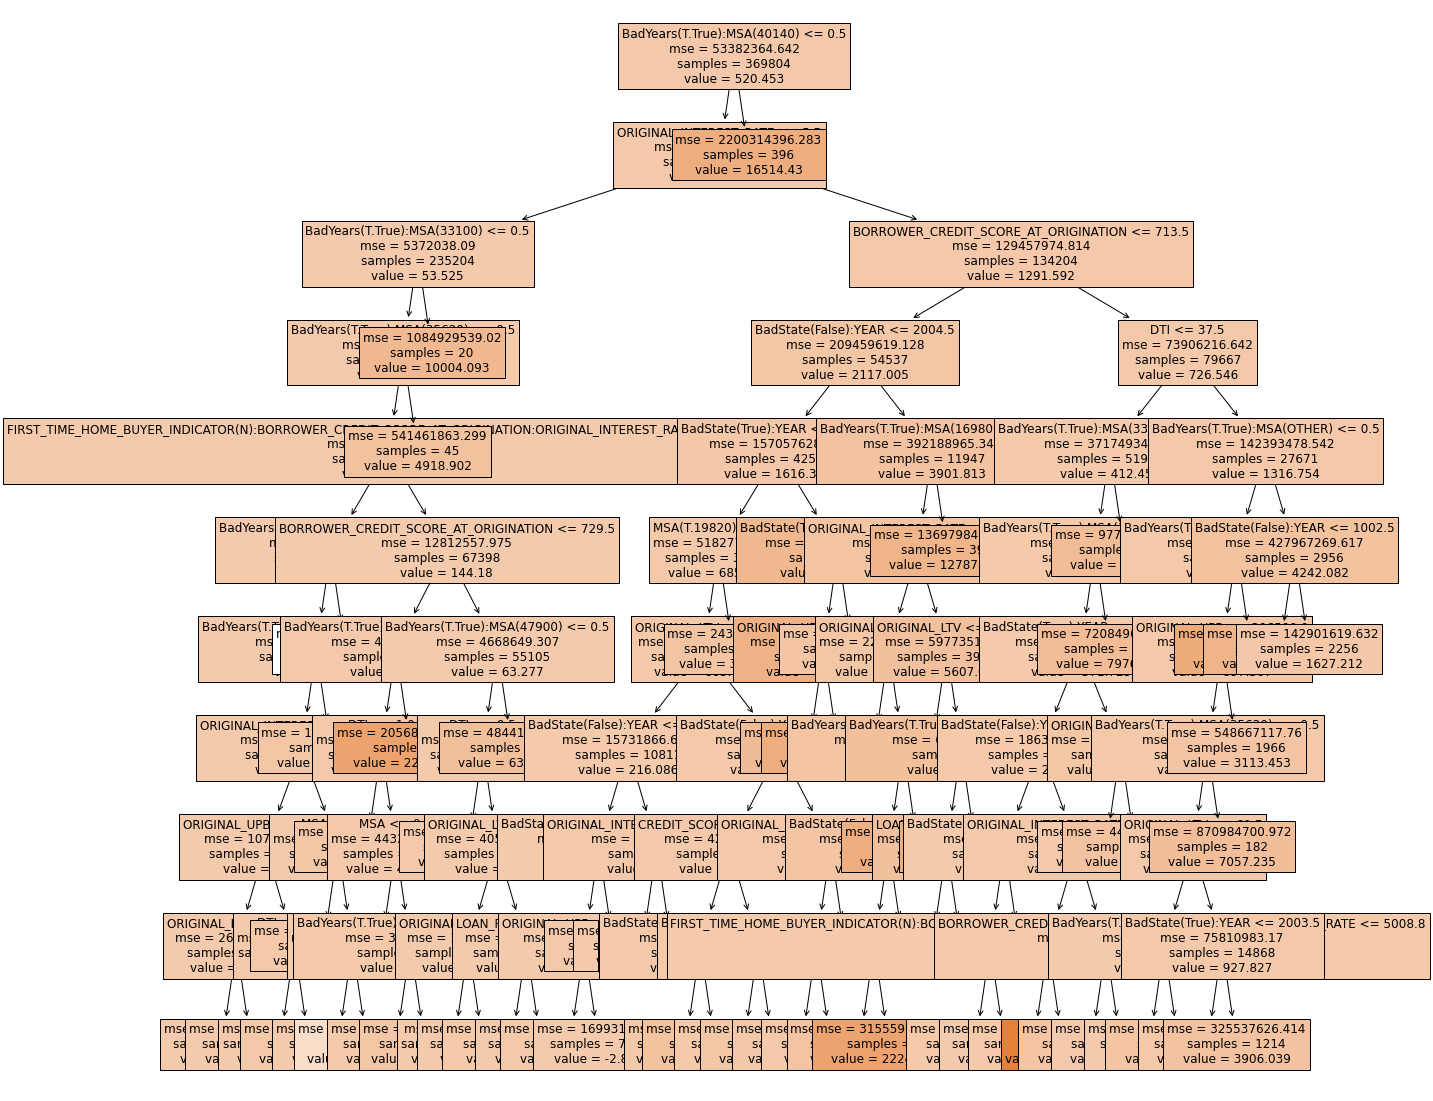

In [44]:
plt.figure(figsize=(20,20))
plot_tree(dt_model, feature_names=X_tree_train.columns, filled=True, fontsize=12)
plt.show()

In [45]:
dt_pred = dt_model.predict(X_tree_validation)

In [46]:
accuracy(df_validation['NET_LOSS'], dt_pred)

RMSE,Naive - RMSE
7239.702103,216.697533


# Random forest

Grid Search to optimize parameters (do not need to run every time)

In [186]:
param_grid = {'max_depth': [10, 15, 20],
              'min_samples_split': [100, 250, 500],
              'max_features': [10,  15,  20],
              'n_estimators': [75, 100, 200]}

In [187]:
from sklearn.model_selection import ParameterGrid
list(ParameterGrid(param_grid))

[{'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 100,
  'n_estimators': 75},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 100,
  'n_estimators': 100},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 100,
  'n_estimators': 200},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 250,
  'n_estimators': 75},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 250,
  'n_estimators': 100},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 250,
  'n_estimators': 200},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 500,
  'n_estimators': 75},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 500,
  'n_estimators': 100},
 {'max_depth': 10,
  'max_features': 10,
  'min_samples_split': 500,
  'n_estimators': 200},
 {'max_depth': 10,
  'max_features': 15,
  'min_samples_split': 100,
  'n_estimators': 75},
 {'max_depth': 10,
  'max_features': 15,
  'min_samples_split': 100,
  'n_

In [188]:
rt_model = GridSearchCV(RandomForestRegressor(max_features = .5, ccp_alpha=10, random_state=201), param_grid=param_grid, cv=2, n_jobs=num_cpus)

In [189]:
rt_model.fit(X_tree_train, y_tree_train)

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(ccp_alpha=10, max_features=0.5,
                                             random_state=201),
             n_jobs=15,
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': [10, 15, 20],
                         'min_samples_split': [100, 250, 500],
                         'n_estimators': [75, 100, 200]})

In [190]:
rt_model.best_params_

{'max_depth': 15,
 'max_features': 10,
 'min_samples_split': 100,
 'n_estimators': 200}

Fit random forest model:

In [47]:
%%time
rf_model = RandomForestRegressor(n_estimators=200,
                                 max_features=10,
                                 max_depth=15,
                                 min_samples_split=100,
                                 min_impurity_decrease=0,
                                 random_state=201,
                                 n_jobs=num_cpus)

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 47.9 µs


In [48]:
rf_model.fit(X_tree_train, y_tree_train)

RandomForestRegressor(max_depth=15, max_features=10, min_impurity_decrease=0,
                      min_samples_split=100, n_estimators=200, n_jobs=15,
                      random_state=201)

In [49]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
BadState(True):YEAR,0.098944
ORIGINAL_LTV,0.076885
ORIGINAL_UPB,0.075491
ORIGINAL_INTEREST_RATE,0.067286
FIRST_TIME_HOME_BUYER_INDICATOR(N):BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_INTEREST_RATE,0.061607
...,...
MSA(T.19100),0.000118
MSA(T.19740),0.000094
BadYears(T.True):MSA(19740),0.000082
MSA(T.31080),0.000074


In [50]:
rf_pred = rf_model.predict(X_tree_validation)

In [51]:
accuracy(df_validation['NET_LOSS'], rf_pred)

RMSE,Naive - RMSE
7143.155761,313.243875


# Boosted trees model

Grid Search to optimize parameters (do not need to run every time)

In [196]:
parametersxb = {'max_depth': [3, 6, 10, 12],
              'n_estimators': [90, 100, 110, 130],
            'learning_rate': [.3, .2, .1]}

In [197]:
from sklearn.model_selection import ParameterGrid
list(ParameterGrid(parametersxb))

[{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 90},
 {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100},
 {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 110},
 {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 130},
 {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 90},
 {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100},
 {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 110},
 {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 130},
 {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 90},
 {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100},
 {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 110},
 {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 130},
 {'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 90},
 {'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 100},
 {'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 110},
 {'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 130},
 {'l

In [198]:
gs_rt_modelxb = GridSearchCV(XGBRegressor(),parametersxb, cv=2, n_jobs=5, verbose=True)

In [199]:
gs_rt_modelxb.fit(X_tree_train, y_tree_train)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [200]:
gs_rt_modelxb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Fit boosted trees model:

In [52]:
xgb_model = XGBRegressor(max_depth=3,
                         n_estimators = 100,
                         learning_rate=.1,
                         ccp_alpha=10,
                         random_state=201)
xgb_model.fit(X_tree_train, y_tree_train)
xgb_pred = xgb_model.predict(X_tree_validation)

[02:50:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:573: 
Parameters: { "ccp_alpha" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [53]:
pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
BadState(False):YEAR,0.155060
BadState(True):YEAR,0.128432
ORIGINAL_LTV,0.073286
BadYears(T.True):MSA(38060),0.067326
BadYears(T.True):MSA(OTHER),0.056422
...,...
BadYears(T.True):MSA(19100),0.000000
BadYears(T.True):MSA(19740),0.000000
MSA(T.33100),0.000000
BadYears(T.True):MSA(26420),0.000000


In [54]:
xgb_pred = xgb_model.predict(X_tree_validation)

In [55]:
accuracy(df_validation['NET_LOSS'], xgb_pred)

RMSE,Naive - RMSE
7178.297958,278.101678


## Ensemble the tree models

Run linear regression of the decision tree, random forest, and boosted trees to find coefficients and intercept

In [56]:
import statsmodels.formula.api as smf

In [57]:
lm_1= smf.ols(formula='NET_LOSS ~ xgb_pred + rf_pred + dt_pred', data=df_validation).fit()
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               NET_LOSS   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3875.
Date:                Sat, 25 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:50:54   Log-Likelihood:            -1.2685e+06
No. Observations:              123269   AIC:                         2.537e+06
Df Residuals:                  123265   BIC:                         2.537e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -146.0377     21.245     -6.874      0.000    -187.677    -104.399
xgb_pred      -0.0574      0.030     -1.930      0.054      -0.116       0.001
rf_pred        1.3355      0.037     36.286      0.000       1.263       1.408
dt_pred       -0.0084      0.019     -0.432      0.666      -0.046       0.030
==============================================================================
Omnibus:                   253065.113   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1894513172.743
Skew:                          17.040   Prob(JB):                         0.00
Kurtosis:                     609.377   Cond. No.                     3.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Predict on the Test Set

Refit the imputers and impute on `df_train` and `df_test`.

In [58]:
imputer_mean_final = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero_final = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer_final = CategoricalImputer(other_threshold=.01)
imputer_missing_final = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='missing')

In [59]:
imputer_mean_final.fit(df_train[continuous_mean])
df_train[continuous_mean] = imputer_mean_final.transform(df_train[continuous_mean])
df_test[continuous_mean] = imputer_mean_final.transform(df_test[continuous_mean])

In [60]:
imputer_zero_final.fit(df_train[continuous_zero])
df_train[continuous_zero] = imputer_zero_final.transform(df_train[continuous_zero])
df_test[continuous_zero] = imputer_zero_final.transform(df_test[continuous_zero])

In [61]:
categorical_imputer_final.fit(df_train[categorical_variables])
df_train[categorical_variables] = categorical_imputer_final.transform(df_train[categorical_variables])
df_test[categorical_variables] = categorical_imputer_final.transform(df_test[categorical_variables])

In [62]:
imputer_missing_final.fit(df_train[categorical_missing])
df_train[categorical_missing] = imputer_missing_final.transform(df_train[categorical_missing])
df_test[categorical_missing] = imputer_missing_final.transform(df_test[categorical_missing])

Recreate the tree based models data set.

In [63]:
X_tree_train_final = df_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train_final = df_train['NET_LOSS']

In [64]:
X_tree_train_final = df_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train_final = df_train['NET_LOSS']

In [65]:
X_tree_train_patsy_final = dmatrix(formula_tree, df_train, return_type="dataframe")
X_tree_train_final = pd.concat([X_tree_train_final, X_tree_train_patsy_final], axis=1)

In [66]:
ordinal_encoder_final = OrdinalEncoder()
ordinal_encoder_final.fit(X_tree_train_final[cat_ordinal_features_trees])
X_tree_train_final[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_train_final[cat_ordinal_features_trees])

In [67]:
X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_133/3936873654.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')


In [68]:
X_tree_test = df_test[continuous_features_trees + cat_ordinal_features_trees]
y_tree_test = df_test['NET_LOSS']

X_tree_test_patsy = build_design_matrices([X_tree_train_patsy_final.design_info], df_test, return_type="dataframe")[0]

X_tree_test = pd.concat([X_tree_test, X_tree_test_patsy], axis=1)

X_tree_test[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_test[cat_ordinal_features_trees])

X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_133/783380200.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')


Decision tree final model (using grid searched parametrs from above):

In [69]:
dt_model_final = DecisionTreeRegressor(max_depth=10,
                                       min_samples_split=2500,
                                       max_features=.5,
                                       min_impurity_decrease=0,
                                       random_state=201)
dt_model_final.fit(X_tree_train_final, y_tree_train_final)
dt_pred_final = dt_model_final.predict(X_tree_test)

Random forest final model (using grid searched parametrs from above):

In [70]:
%%time
rf_model_final = RandomForestRegressor(n_estimators=200,
                                 max_features=10,
                                 max_depth=15,
                                 min_samples_split=100,
                                 min_impurity_decrease=0,
                                 random_state=201,
                                 n_jobs=num_cpus)
rf_model_final.fit(X_tree_train_final, y_tree_train_final)
rf_pred_final = rf_model_final.predict(X_tree_test)

CPU times: user 4min 37s, sys: 286 ms, total: 4min 37s
Wall time: 19.3 s


Boosted tree final model (using grid searched parametrs from above):

In [71]:
xgb_model_final = XGBRegressor(max_depth=3,
                         n_estimators = 100,
                         learning_rate=.1,
                         ccp_alpha=10,
                         random_state=201)
xgb_model_final.fit(X_tree_train_final, y_tree_train_final)
xgb_pred_final = xgb_model_final.predict(X_tree_test)

[02:51:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1631904754241/work/src/learner.cc:573: 
Parameters: { "ccp_alpha" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Final prediction code

Use intercepts and coefficients from lm_1.summary() above

In [72]:
final_pred = (1.3355*rf_pred_final -0.0574*xgb_pred_final -0.0084*dt_pred_final)-146.0377

Skill score on your final prediction.

In [73]:
accuracy(df_test['NET_LOSS'], final_pred)

RMSE,Naive - RMSE
7044.939939,319.565878


## Write out the data with your predictions

In [74]:
%%time
if not full_data_set:
    df_test_fresh = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')
elif full_data_set:
    df_test_fresh = pd.read_csv(FILES_LOCATION + "FannieMaeTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

CPU times: user 2.96 s, sys: 72.1 ms, total: 3.03 s
Wall time: 3.05 s


Write out predictions to `df_test_fresh` data set

In [75]:
df_test_fresh['PREDICTIONS_NET_LOSS'] = final_pred

In [76]:
df_test_fresh.to_csv('FannieMaeTestWithPredictionsNetLoss.csv', sep='|')